![logo.JPG](data/img/logo.JPG)
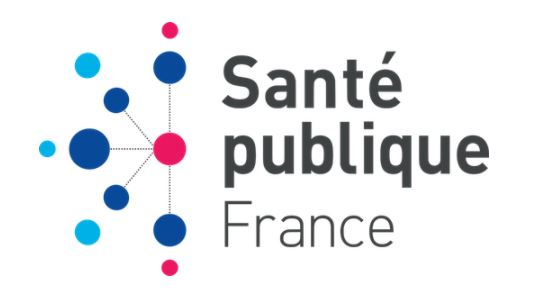

In [175]:
# Importation des librairies python spécialisées dans le Jupyter Notebook
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

In [176]:
# Affiche la taille du jeu de données
def displayDataShape(data):
    shape = data.shape
    print(f"Le jeu de données contient : {shape[0]} lignes et {shape[1]} colonnes\n")

# Affichage des Nan en %
def displayNanPercent(data):
    missing_values = pd.DataFrame((data.isna().mean()*100).sort_values())
    missing_values.columns = ['Valeurs manquantes en %']
    return missing_values

# Retourne le data en filtrant par % de NaN dans les colonnes
def filterDataColumnByNan(data, limit_nan=0.75):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    return data[data.columns[data.isna().mean() <= limit_nan]].copy()

# Retourne le data en filtrant par % de Nan dans les lignes, filtré par colonnes contenant la mention "_100g" (quantité d'un nutriment pour 100g du produit)
def filterDataRowByNan(data, limit_nan=1):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    nutriment_amount_tag = "_100g"
    data_columns_filtered = data[[col for col in data.columns if col.endswith(nutriment_amount_tag)]]
    index_with_nan = data_columns_filtered.index[data_columns_filtered.isnull().mean(axis=1) == limit_nan]

    return data.drop(index=index_with_nan).copy()

# Retourne le data en filtrant les lignes qui ont des valeurs à NaN dans la colonne passée en paramètre
def filterDataRowByNanInColumn(data, column_name):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    return data[data[column_name].notna()].copy()

# Affiche le nombre de valeurs uniques pour chaque colonne dans le tableau passé en paramètres
def displayNbrUnique(data, columns):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    nbr_uniques = []

    for column in columns:
        nbr_uniques.append(data[column].nunique())

    return pd.Series(nbr_uniques, index=columns)

# Retourne 2 tableaux contenant les noms des colonnes des valeurs quantitatives et des valeurs qualitatives
def categoriseVariables(data):
    infos_type = data.dtypes
    quantitative_columns = []
    qualitative_columns = []

    for index in infos_type.index:
        if (infos_type[index] == 'float') | (infos_type[index] == 'int'):
            quantitative_columns.append(index)
        else:
            qualitative_columns.append(index)

    return quantitative_columns, qualitative_columns

def cleanDataOutInterval(data, columns, min, max):
    if type(data) != type(pd.DataFrame()):
        raise ValueError(f"data n\'est pas un DataFrame, mais est de type {type(data)}!")

    for column in columns:
        if "_100g" in column and "energy" not in column and "score" not in column:
            data[column] = data[column].apply(replaceValuesInColumn, args=(min, max, np.nan))

    return data

def replaceValuesInColumn(value, min, max, new_value):
    if (value < min) | (value > max):
        value = new_value
    return value

def removeOutliers(data, columns):
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    EI = Q3 - Q1

    outliers = (data[columns] >= (Q1 - 1.5 * EI)) & (data[columns] <= (Q3 + 1.5 * EI))

    return outliers

def drawHist(data, columns, dims_fig):
    nbr_rows = int(len(columns)/3) + 1
    index = 1
    plt.figure(figsize=dims_fig)
    for column in columns:
        plt.subplot(nbr_rows, 3, index)
        plt.hist(data[column])
        plt.xlabel(f"{column}")
        plt.ylabel("Nombre d'aliments")
        plt.title(f"Histogramme - {column}")
        index += 1
    plt.show()

# Affiche les informations supprimées entre le data et le data nettoyé
def displayInfosDataCleaned(data, data_cleaned):
    print(f"Nombre de lignes supprimées : {data.shape[0] - data_cleaned.shape[0]}")
    print(f"Nombre de colonnes supprimées : {data.shape[1] - data_cleaned.shape[1]}")
    print(f"Colonnes supprimées : {[col for col in data.columns if col not in data_cleaned.columns]}\n")
    displayDataShape(data_cleaned)

In [177]:
data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
displayDataShape(data)

Le jeu de données contient : 320772 lignes et 162 colonnes



ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of ticklabels (162).

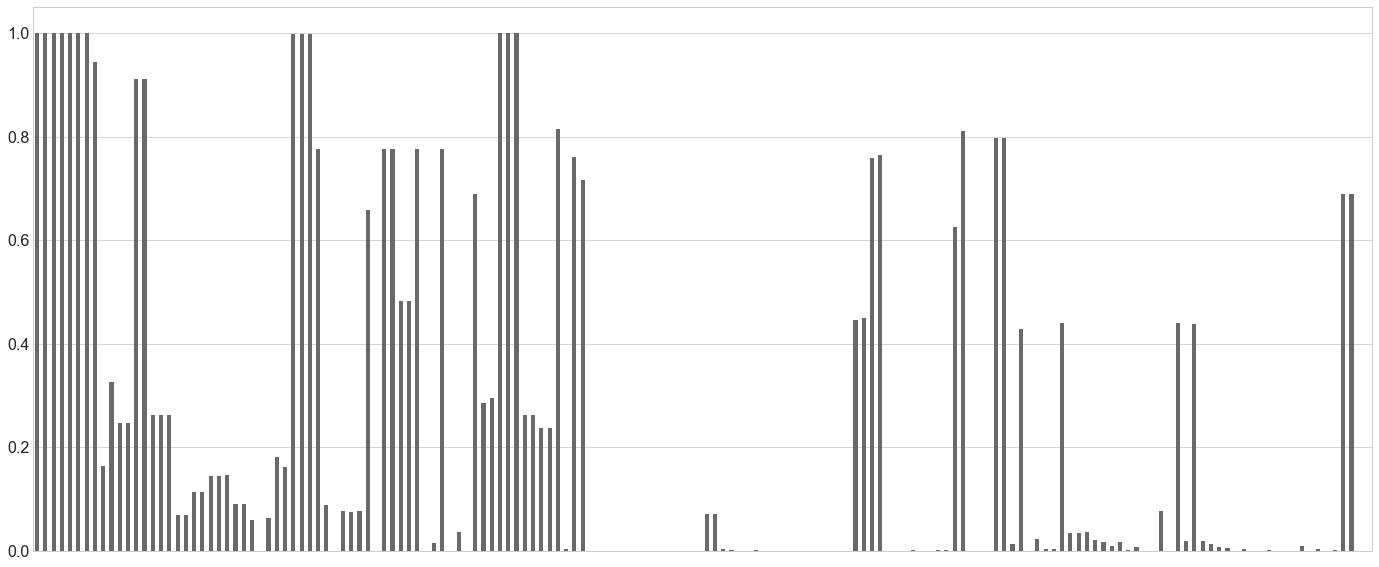

In [194]:
msno.bar(data)

In [178]:
data_cleaned = filterDataColumnByNan(data)

In [179]:
data_cleaned = filterDataRowByNan(data_cleaned)

In [180]:
data_cleaned = filterDataRowByNanInColumn(data_cleaned, 'code')

In [181]:
displayInfosDataCleaned(data, data_cleaned)

Nombre de lignes supprimées : 57955
Nombre de colonnes supprimées : 112
Colonnes supprimées : ['generic_name', 'packaging', 'packaging_tags', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'image_url', 'image_small_url', 'energy-from-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsatura

In [182]:
data_cleaned[data_cleaned.duplicated(['code','product_name'])].sort_values('code')

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g


<AxesSubplot:>

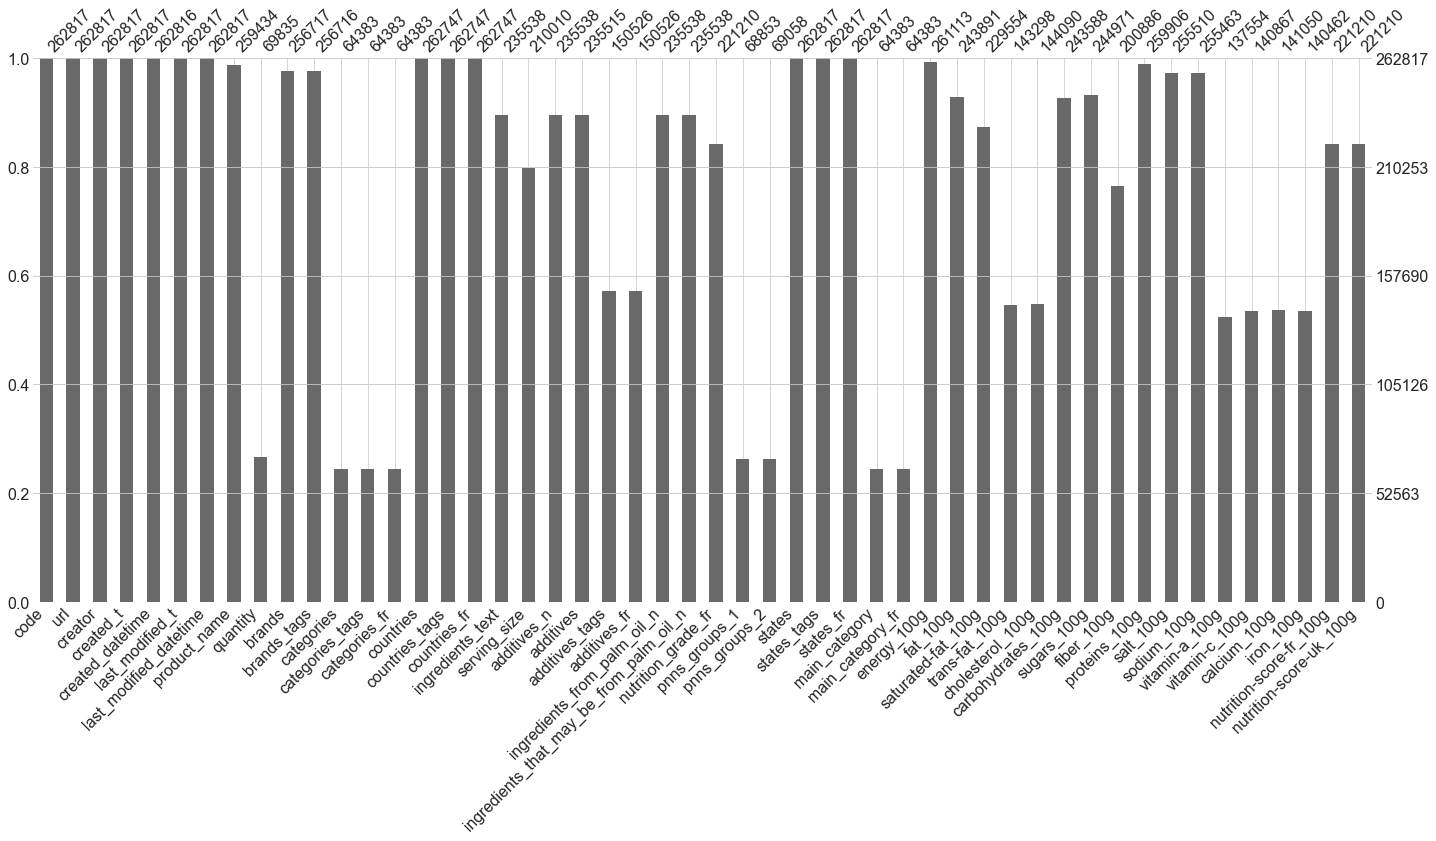

In [183]:
msno.bar(data_cleaned)

In [184]:
data_cleaned.head(20)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.000000,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,Torn & Glasser,...,7.1,17.86,0.63500,0.250,0.000000,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,Grizzlies,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,Bob's Red Mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000016100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,Unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
6,0000000016117,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055730,2017-03-09T10:35:30Z,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,Lundberg,...,NaN,8.89,NaN,NaN,NaN,0.0027,0.044,NaN,NaN,NaN
7,0000000016124,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055711,2017-03-09T10:35:11Z,1489055712,2017-03-09T10:35:12Z,Organic Muesli,NaN,Daddy's Muesli,...,9.4,14.06,0.13970,0.055,NaN,NaN,0.062,0.00422,7.0,7.0
8,0000000016193,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,Equal Exchange,...,7.5,5.00,NaN,NaN,NaN,NaN,0.050,0.01125,NaN,NaN
9,0000000016513,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055654,2017-03-09T10:34:14Z,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,NaN,Napa Valley Naturals,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0000000016612,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Adzuki Beans,NaN,Unfi,...,12.5,22.92,NaN,NaN,NaN,NaN,0.062,0.00450,NaN,NaN


In [185]:
quanti,quali = categoriseVariables(data_cleaned)

In [186]:
displayNbrUnique(data_cleaned, quali)

code                      262817
url                       262817
creator                     2528
created_t                 132929
created_datetime          132928
last_modified_t           126164
last_modified_datetime    126164
product_name              187506
quantity                    9872
brands                     46573
brands_tags                40989
categories                 28761
categories_tags            16571
categories_fr              16571
countries                   1039
countries_tags               557
countries_fr                 557
ingredients_text          194351
serving_size               25232
additives                 185916
additives_tags             40152
additives_fr               40152
nutrition_grade_fr             5
pnns_groups_1                 14
pnns_groups_2                 42
states                       547
states_tags                  547
states_fr                    547
main_category               2390
main_category_fr            2390
dtype: int

In [187]:
data_cleaned[quanti].describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,235538.000000,235538.000000,235538.000000,2.611130e+05,243891.000000,229554.000000,143298.000000,144090.000000,243588.000000,244971.000000,200886.000000,259906.000000,255510.000000,255463.000000,137554.000000,140867.000000,141050.000000,140462.000000,221210.000000,221210.000000
mean,1.993050,0.019555,0.054993,1.141915e+03,12.730379,5.129932,0.073476,0.020071,32.073981,16.003484,2.862111,7.076366,2.028624,0.798815,0.000397,0.023367,0.125163,0.003652,9.165535,9.058049
std,2.515141,0.140173,0.267218,6.447154e+03,17.578747,8.014238,1.540223,0.358062,29.731719,22.327284,12.867578,8.409137,128.269454,50.504428,0.073278,2.236451,3.318263,0.214408,9.055903,9.183589
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000,-0.000340,-0.002100,0.000000,-0.000260,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,3.770000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.100000e+03,5.000000,1.790000,0.000000,0.000000,20.600000,5.710000,1.500000,4.760000,0.581660,0.229000,0.000000,0.000000,0.035000,0.001010,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1.674000e+03,20.000000,7.140000,0.000000,0.020000,58.330000,24.000000,3.600000,10.000000,1.374140,0.541000,0.000107,0.003700,0.106000,0.002400,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,369.000000,95.238000,2916.670000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,26.700000,716.981100,694.737000,50.000000,40.000000,40.000000


In [188]:
cleanDataOutInterval(data_cleaned, quanti, 0, 100)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,Torn & Glasser,...,7.1,17.86,0.63500,0.250000,0.0,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,Grizzlies,...,7.1,17.86,1.22428,0.482000,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,Bob's Red Mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000016100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,Unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320756,989898,http://world-fr.openfoodfacts.org/produit/9898...,openfoodfacts-contributors,1473694809,2016-09-12T15:40:09Z,1473694815,2016-09-12T15:40:15Z,Test NF App,100gr,NaN,...,1.1,2.10,1.10000,0.433071,NaN,NaN,NaN,NaN,NaN,NaN
320757,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,1491079938,2017-04-01T20:52:18Z,1491079939,2017-04-01T20:52:19Z,Amandes,NaN,Biosic,...,12.2,21.22,0.10000,0.039370,NaN,NaN,NaN,NaN,0.0,0.0
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,50 g,Lobodis,...,0.2,0.50,0.02540,0.010000,NaN,NaN,NaN,NaN,2.0,0.0
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,Trader Joe's,...,0.0,0.00,0.00000,0.000000,0.0,0.0000,0.000,0.00000,0.0,0.0


In [189]:
data_cleaned[quanti].describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,235538.000000,235538.000000,235538.000000,2.611130e+05,243887.000000,229551.000000,143289.000000,144090.000000,243569.000000,244952.000000,200881.000000,259902.000000,255352.000000,255429.000000,137553.000000,140863.000000,141040.000000,140461.000000,221210.000000,221210.000000
mean,1.993050,0.019555,0.054993,1.141915e+03,12.725256,5.125925,0.067172,0.020071,32.055323,15.985449,2.832473,7.079837,1.588497,0.647145,0.000397,0.014563,0.102023,0.003653,9.165535,9.058049
std,2.515141,0.140173,0.267218,6.447154e+03,17.503695,7.913684,0.945020,0.358062,29.140680,21.165362,4.588272,8.156621,6.242531,2.656343,0.073279,0.461423,0.585288,0.214409,9.055903,9.183589
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,3.770000e+02,0.000000,0.000000,0.000000,0.000000,6.000000,1.300000,0.000000,0.700000,0.063500,0.025000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.100000e+03,5.000000,1.790000,0.000000,0.000000,20.600000,5.710000,1.500000,4.760000,0.580000,0.229000,0.000000,0.000000,0.035000,0.001010,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1.674000e+03,20.000000,7.140000,0.000000,0.020000,58.330000,24.000000,3.600000,10.000000,1.371600,0.541000,0.000107,0.003700,0.106000,0.002400,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,100.000000,100.000000,100.000000,95.238000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,26.700000,100.000000,99.006000,50.000000,40.000000,40.000000


In [190]:
outliers = removeOutliers(data_cleaned, quanti)
data_cleaned[quanti][outliers].describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,226012.000000,230988.0,224467.0,260033.000000,235491.000000,212307.000000,140297.0,123149.000000,243569.000000,229656.000000,186758.000000,247313.000000,239019.000000,238977.000000,120597.000000,118343.000000,128946.000000,133912.000000,221206.000000,221207.000000
mean,1.650974,0.0,0.0,1114.353744,10.489088,3.502599,0.0,0.005844,32.055323,12.130217,1.914766,5.888054,0.718245,0.282850,0.000038,0.000874,0.048878,0.001290,9.164977,9.057629
std,1.838437,0.0,0.0,781.782167,12.693443,4.548423,0.0,0.011886,29.140680,15.161924,2.213757,5.998753,0.774157,0.304824,0.000064,0.001965,0.058714,0.001404,9.055036,9.182945
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.0,0.0,372.000000,0.000000,0.000000,0.0,0.000000,6.000000,1.070000,0.000000,0.500000,0.048260,0.019000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.0,0.0,1094.000000,4.350000,1.400000,0.0,0.000000,20.600000,4.800000,1.200000,4.230000,0.475000,0.188000,0.000000,0.000000,0.026000,0.000900,10.000000,9.000000
75%,3.000000,0.0,0.0,1674.000000,18.000000,5.700000,0.0,0.004000,58.330000,18.400000,3.300000,9.000000,1.186180,0.467000,0.000062,0.000000,0.079000,0.002180,16.000000,16.000000
max,7.000000,0.0,0.0,3619.000000,50.000000,17.840000,0.0,0.050000,100.000000,58.000000,9.000000,23.940000,3.332480,1.315000,0.000267,0.009230,0.265000,0.006000,38.000000,38.000000


In [191]:
data_cleaned[quanti] = data_cleaned[quanti][outliers]
data_cleaned

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000000,0.0,NaN,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,Torn & Glasser,...,7.1,17.86,0.63500,0.250000,0.0,0.0,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,Grizzlies,...,7.1,17.86,1.22428,0.482000,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,Bob's Red Mill,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000000016100,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055651,2017-03-09T10:34:11Z,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,Unfi,...,7.7,13.46,NaN,NaN,NaN,NaN,0.038,0.00346,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320756,989898,http://world-fr.openfoodfacts.org/produit/9898...,openfoodfacts-contributors,1473694809,2016-09-12T15:40:09Z,1473694815,2016-09-12T15:40:15Z,Test NF App,100gr,NaN,...,1.1,2.10,1.10000,0.433071,NaN,NaN,NaN,NaN,NaN,NaN
320757,9900000000233,http://world-fr.openfoodfacts.org/produit/9900...,kiliweb,1491079938,2017-04-01T20:52:18Z,1491079939,2017-04-01T20:52:19Z,Amandes,NaN,Biosic,...,NaN,21.22,0.10000,0.039370,NaN,NaN,NaN,NaN,0.0,0.0
320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,50 g,Lobodis,...,0.2,0.50,0.02540,0.010000,NaN,NaN,NaN,NaN,2.0,0.0
320768,99567453,http://world-fr.openfoodfacts.org/produit/9956...,usda-ndb-import,1489059076,2017-03-09T11:31:16Z,1491244499,2017-04-03T18:34:59Z,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,Trader Joe's,...,0.0,0.00,0.00000,0.000000,0.0,0.0,0.000,0.00000,0.0,0.0


In [192]:
# Réglage des graphiques

plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

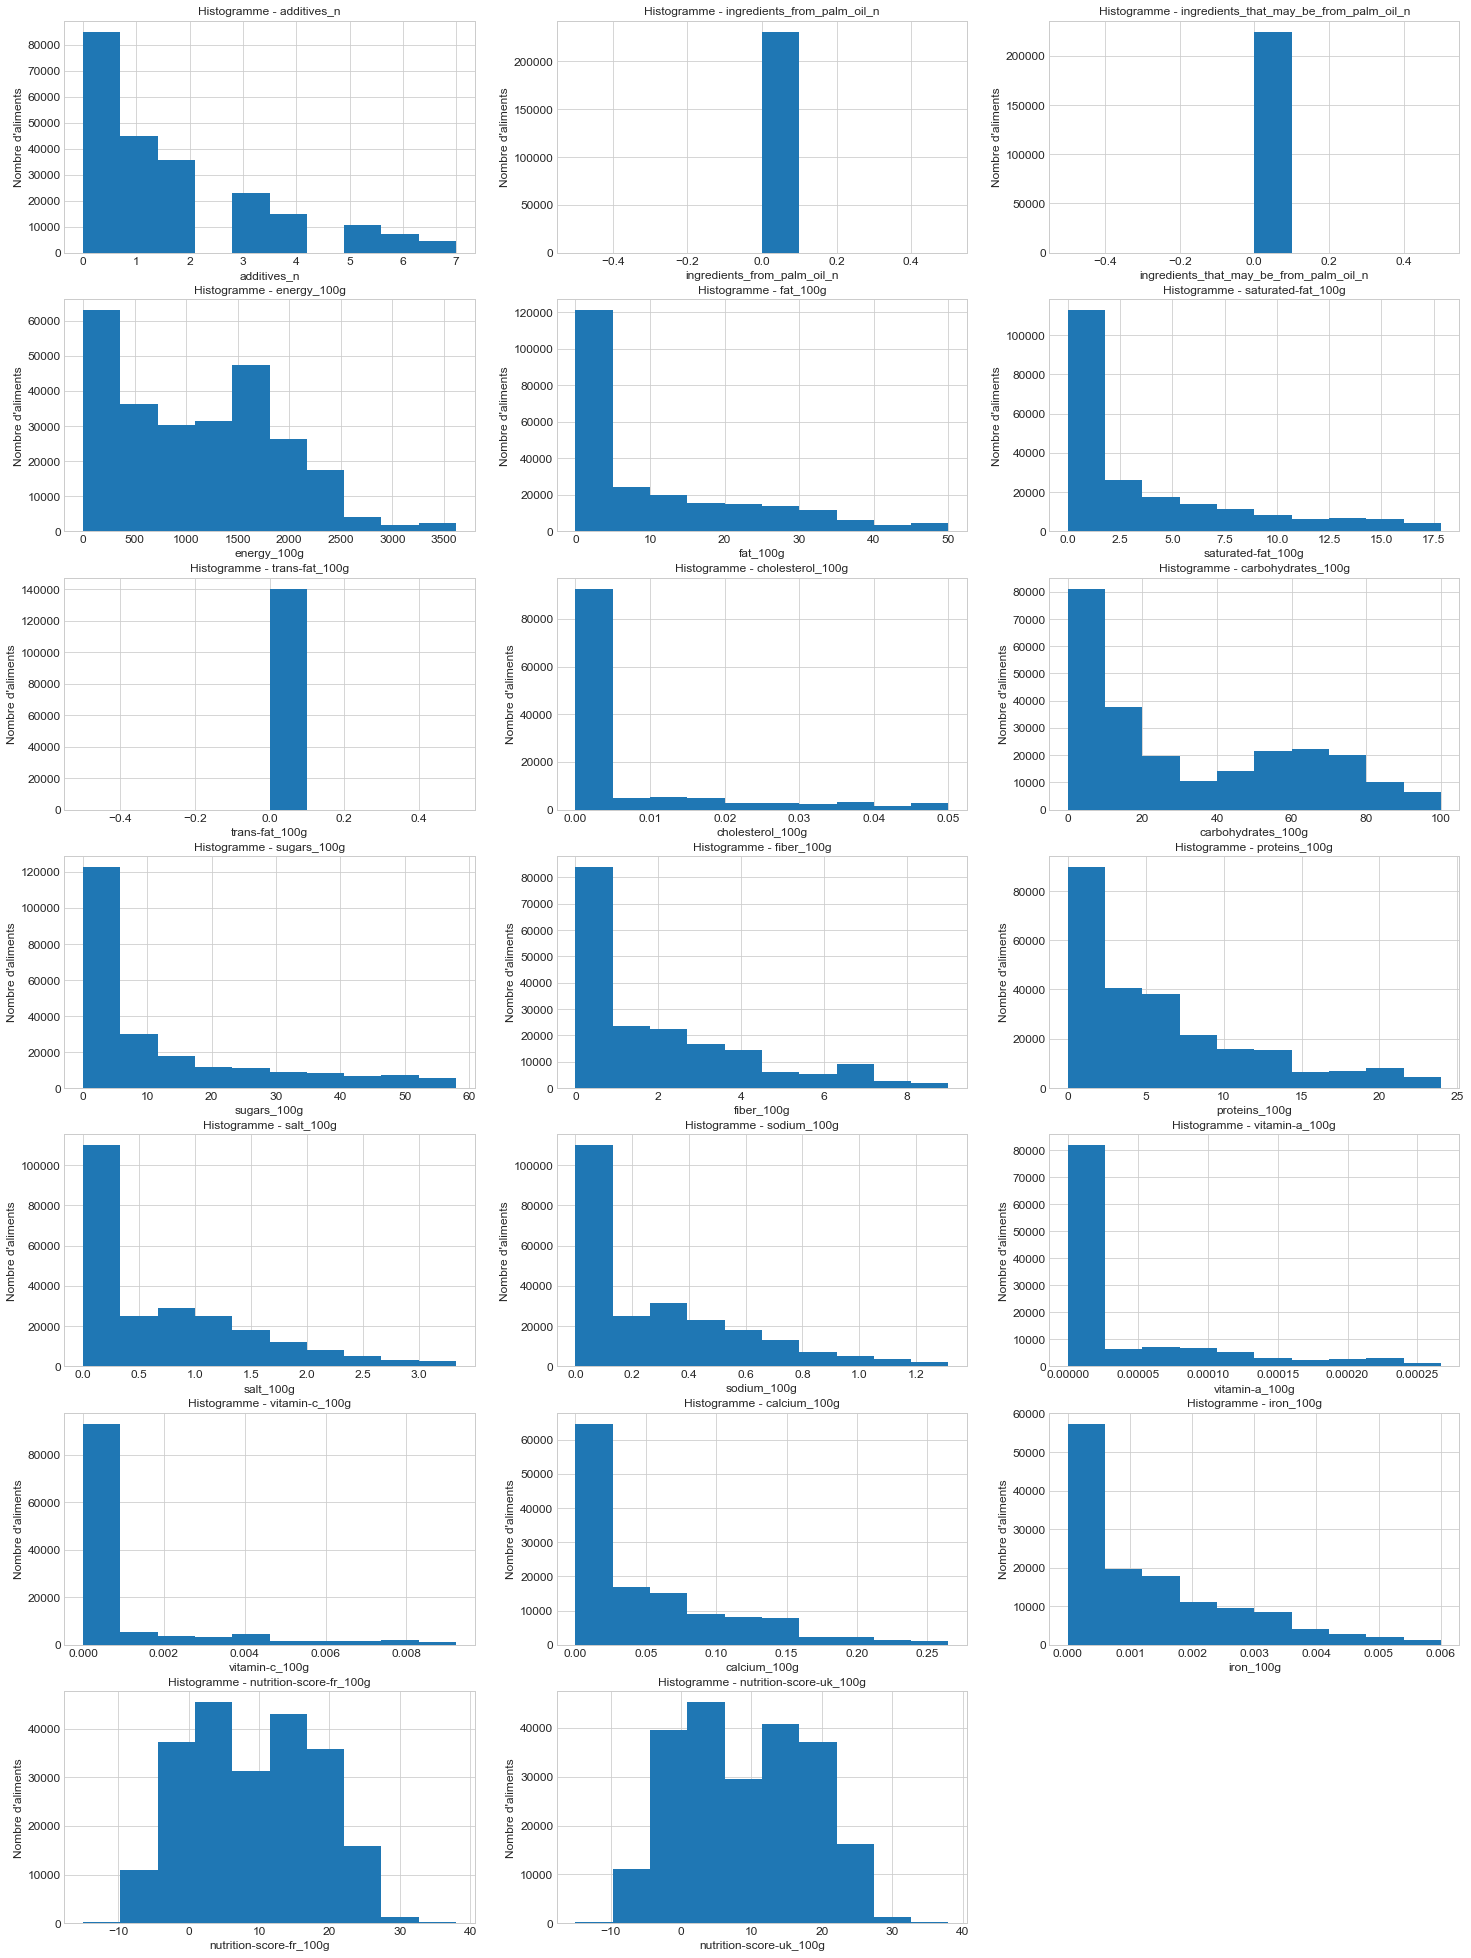

In [193]:
drawHist(data_cleaned, quanti, dims_fig)